# Fit vertical mode to SUNTANS harmonic data

$$
b(z,t) = A(t)N^2(z)\phi(z)
$$

In [1]:

from soda.dataio.suntans.suntides import suntides
from soda.dataio.suntans.sunpy import Spatial

from iwaves.utils.isw import iwave_modes_uneven

from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg as la

from glob import glob
import pdb

In [2]:
###
sunfile = '../SCENARIOS/OUTPUT_NWS_5km_hex/NWS_5kkm_20140101_20140131_3D_Harmonics.nc'

outfile = '../SCENARIOS/OUTPUT_NWS_5km_hex/NWS_5kkm_20140101_20140131_3D_ModeAmp.nc'

nmodes = 5
mindepth = 100.
###

In [3]:
#Constants
RHO0=1024.
g=9.81

# Load the object
sun=suntides(sunfile)
Nf=sun.frq.shape[0]

# Re-calculate the grid variables
#sun.reCalcGrid()
sun.calc_def()


## calculate the buoyancy frequecny
#rho = sun.loadData(variable='rho')*1000.0
rho = sun.Mean['rho']*1000

# Get the mask array
mask = rho >= 999999.
mask3d = np.tile(mask,(Nf,1,1))

rho[mask]=0

print 'Calculating N^2...'
N2 = -g/RHO0 * sun.gradZ(rho)
N2[N2<1e-5]=1e-5
N2[mask]=0

# Put everything in complex form
print 'Converting arrays into complex form...'
rho = sun.Amp['rho']*1000.0*np.cos(sun.Phs['rho']) + 1j * sun.Amp['rho']*1000.0*np.sin(sun.Phs['rho'])

# Mask these arrays
rho[mask3d]=0

# Calculate the buoyancy perturbation
b =  -g/RHO0 * rho



Loading: ../SCENARIOS/OUTPUT_NWS_5km_hex/NWS_5kkm_20140101_20140131_3D_Harmonics.nc
Cannot find variable: time
Warning - no cartographic projection specified
Warning - no cartographic projection specified
No time variable.
Loading existing harmonic data...
Loading eta harmonic data...
Loading uc harmonic data...
Loading vc harmonic data...
Loading w harmonic data...
Loading rho harmonic data...
Calculating N^2...
Converting arrays into complex form...


In [9]:
nf, nz, nc = b.shape

In [5]:
def mid_extrap(A, nk):
    B = np.zeros((nk+1,), dtype=A.dtype)
    B[1:-1] = 0.5*A[0:-1]+0.5*A[1::]
    B[0] = B[1]
    B[-1] = B[-2]
    return B


# Create the output arrays
cnall = np.zeros((nmodes, nc))
phiall = np.zeros((nz+1, nc, nmodes)) # Put modes last so we can array multiply
ampall = np.zeros((nf, nc, nmodes), dtype=np.complex)
N2out = np.zeros((nz+1, nc)) # Put modes last so we can array multiply


maxamp = 0.
for ii in range(nc):
    if ii%1000 == 0:
        print "%d of %d (max amp = %3.1f m)..."%(ii,nc, maxamp)
        maxamp = 0.

    # Extract the N2 profile at a point
    nk = sun.Nk[ii]
    
    if nk < 10:
        continue

    myN2 = N2[0:nk,ii]
    z = -sun.z_r[0:nk]
    zw = -sun.z_w[0:nk+1]

    # Interpolate N2 onto the edge points
    N2mid = mid_extrap(myN2, nk)

    # Calculate the mode shapes
    phi, cn = iwave_modes_uneven(N2mid, zw)

    # for each frequency
    for ff in range(nf):
        # Get buoyancy at cell-edges
        myb = b[ff,0:nk,ii]
        bmid = mid_extrap(myb, nk)

        # Compute the LHS
        L = phi[:,0:nmodes] * N2mid[:,np.newaxis]

        myamp,_,_,_ = la.lstsq(L, bmid)

        ampall[ff,ii,:] = myamp
        
        if myamp.max() > maxamp:
            maxamp = myamp.max()*1

    # Output the variables
    cnall[:,ii] = cn[0:nmodes]
    phiall[0:nk+1,ii,:] = phi[:,0:nmodes]
    N2out[0:nk+1,ii] = N2mid




0 of 94374 (max amp = 0.0 m)...


/home/suntans/anaconda/envs/suntans/lib/python2.7/site-packages/ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


1000 of 94374 (max amp = 38.9 m)...


KeyboardInterrupt: 

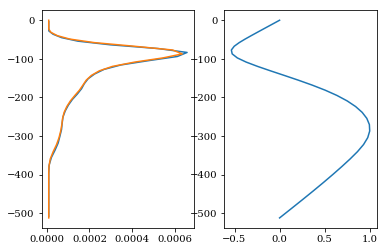

In [7]:
plt.subplot(121)
plt.plot(myN2,z)
plt.plot(N2mid,zw)

plt.subplot(122)
plt.plot(phi[:,1],zw)

plt.show()

In [10]:
# Write the output to netcdf
print 'Writing the output to netcdf...'

sun.writeNC(outfile)

nc = Dataset(outfile,'a')
nc.Title = 'SUNTANS harmonic modal amplitudes'
nc.Constituent_Names = ' '.join(sun.frqnames)

# Add another dimension
nc.createDimension('Ntide', nf)
nc.createDimension('Nmode', nmodes)
nc.close()

coords = 'xv yv Ntides'

sun.create_nc_var(outfile, 'cn', ('Nmode','Nc'),\
        {'long_name':'Baroclinic phase speed',\
         'units':'m s-1',\
         'coordinates':coords})

sun.create_nc_var(outfile, 'phi', ('Nkw','Nc', 'Nmode'),\
        {'long_name':'Vertical eigenfunction',\
         'units':'',\
         'coordinates':coords})

sun.create_nc_var(outfile, 'Amp_b_re', ('Ntide','Nc', 'Nmode'),\
        {'long_name':'Buoyancy real amplitude',\
         'units':'m s-2',\
         'coordinates':coords})

sun.create_nc_var(outfile, 'Amp_b_im', ('Ntide','Nc', 'Nmode'),\
        {'long_name':'Buoyancy imaginary amplitude',\
         'units':'m s-2',\
         'coordinates':coords})

# Write the data

print 'Writing the variable data to netcdf...'

nc = Dataset(outfile,'a')
nc.variables['cn'][:]=cnall
nc.variables['phi'][:]=phiall
nc.variables['amp_b_re'][:]=np.real(ampall)
nc.variables['amp_b_im'][:]=np.imag(ampall)

nc.close()

print 'Done.'

Writing the output to netcdf...


IOError: [Errno 13] Permission denied: '../SCENARIOS/OUTPUT_NWS_5km_hex/NWS_5kkm_20140101_20140131_3D_ModeAmp.nc'